<h1 align = "center">Regression Analysis</h1>

<p align = "justify">In <i>statistical modeling</i>, <b><i>regression analysis</b></i> is a defined set of approach of predicting continuous "target" variable from a set(s) of "independent" variable. The most common type of analysis is called as the <i>linear regression</i> where a "linear" relationship is maintained by an equation like:</p>

$$
  y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n
$$

where, $\beta_0$ is the constant coefficient, and $\beta_1, \beta_2, ..., \beta_n$ are weight involved with each independent variable $x_1, x_2, ..., x_n$, $n$ is the number of independent feature and $y$ is the target.

## Non-Linear Regression

<p align = "justify">When the dependent variable is not linearly dependent with the target, then prediction of such a term is defined as non-linear regression analysis. Often this is used interchangbly with "polynomial regression" however, they are bit different.</p>

## Prediction of Fuel Efficiency

<p align = "justify">In this basic tutorial, will be using the classic <a href = "https://archive.ics.uci.edu/ml/datasets/auto+mpg">Auto MPG</a> dataset to build and predict the fuel efficiency for the given automobiles. The notebook and code(s) are referred from <a href = "https://www.tensorflow.org/tutorials/keras/regression">tensorflow documentations</a> while some parts are modified as required.</p>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%precision 3
%matplotlib inline
sns.set_style('whitegrid');
plt.style.use('default-style'); # https://gitlab.com/ZenithClown/computer-configurations-and-setups
pd.set_option('display.max_rows', 50) # max. rows to show
pd.set_option('display.max_columns', 15) # max. cols to show
np.set_printoptions(precision = 3, threshold = 15) # set np options
pd.options.display.float_format = '{:,.2f}'.format # float precisions

In [3]:
import tensorflow as tf # base library

# in addition, it is often easier to work with the keras api
# import the `keras` and `layer` functionality, to reduce code
from tensorflow import keras
from tensorflow.keras import layers

# check the tensorflow version,
# different version has some compatibility issues
# currently using v2.8.0 (tensorboard v2.8.0) version
print(f"Tensorflow Version: {tf.__version__}", end = " | ")

# check the list of physical available devices
# if `gpu` is configured, then it should be displayed
tf.config.list_physical_devices() # for tf >= 2.x

# in addition, the user is also prompted if `GPU` is available
# using the functionalities available under 2.x version
if len(tf.config.list_physical_devices(device_type = "GPU")):
    # https://stackoverflow.com/q/38009682/6623589
    # https://stackoverflow.com/a/59179238/6623589
    print("GPU Computing Available.")
else:
    print("GPU Computing Not Available. If `GPU` is present, check configuration.")

Tensorflow Version: 2.8.0 | GPU Computing Available.


### Getting the Auto MPG Dataset

In [23]:
dataset = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data", # url for the data
    names = ["mpg", "cylinders", "displacement", "hp", "wt", "accelaration", "year", "origin"],
    comment = "\t", sep = " ", skipinitialspace = True
)

dataset.sample(5)

,mpg,cylinders,displacement,hp,wt,accelaration,year,origin
253,20.50,6,200.00,95.00,"3,155.00",18.20,78,1
7,14.00,8,440.00,215.0,"4,312.00",8.50,70,1
397,31.00,4,119.00,82.00,"2,720.00",19.40,82,1
193,24.00,6,200.00,81.00,"3,012.00",17.60,76,1
388,26.00,4,156.00,92.00,"2,585.00",14.50,82,1


In [16]:
# let's check the number of nulls in the total dataset
_na_values_ = dataset.isnull().sum()
if _na_values_.sum():
    # only runs when there are nulls
    print(_na_values_)
else:
    print("Data does not contain `NaN` values.")

Data does not contain `NaN` values.


**Note:** In the tutorial, there are `6` null values in `hp` column, but at the time of coding this is missing, and is thus ignored.

#### Categorical Columns

The `origin` is a categorical column. The column is thus "one-hot encoded" using the [`pd.get_dummies`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) function.

In [24]:
origin = {1: "USA", 2: "EURO", 3: "JAP"}

dataset["origin"] = dataset["origin"].map(origin)
dataset = pd.get_dummies(dataset, columns = ["origin"], prefix = "", prefix_sep = "")

dataset.sample()

,mpg,cylinders,displacement,hp,wt,accelaration,year,EURO,JAP,USA
327,36.40,5,121.00,67.00,"2,950.00",19.90,80,1,0,0


In [25]:
train = dataset.sample(frac = 0.8, random_state = 7)
test = dataset.drop(train.index) # remove the index present in the training set

print(train.shape, test.shape) # show the data shape, i.e. no of records for analysis

(318, 10) (80, 10)


### Exploratory Data Analysis

<p align = "justify">The <b>objective</b> is to predict the fuel effiiciency (i.e. `mpg`) of a given automobile. For this, let's first understand the correlation of the features against fuel efficiency.</p>

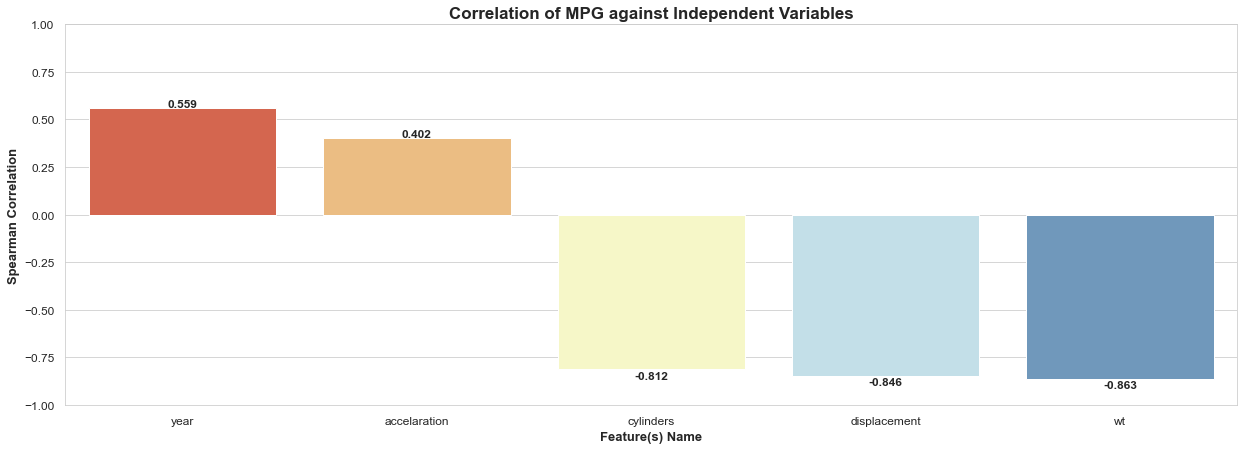

In [40]:
# using the `pd.corr()` to get the correlation, and extract the correlation of the fuel efficiency column
# convert the series `pd.corr()["column"]` to dataframe using `reset_index` command and finally, sort descending
# in addition, drop `index = 0` from `corr` as index = 0 will always given the correlation against self, thus rmeoved
corr = train.drop(columns = origin.values()) \
       .corr(method = "spearman").round(3)["mpg"].reset_index() \
       .drop(index = 0).sort_values(by = "mpg", ascending = False)

axs = sns.barplot(x = "index", y = "mpg", data = corr, palette = sns.color_palette("RdYlBu", corr.shape[0]).as_hex())

# also display the correlation values on the graph
# ? is `annot = True` available for `sns.barplot` model
corr = corr["mpg"].values # returns a ndarray
for tick in range(len(axs.get_xticklabels())):
    y_pos = corr[tick] + 5e-3 if corr[tick] > 0 else corr[tick] - 5e-2
    axs.text(tick, y_pos, str(corr[tick]), ha = "center", weight = "bold")

axs.set_ylim(-1, 1)
axs.set(xlabel = "Feature(s) Name")
axs.set(ylabel = "Spearman Correlation")

plt.title("Correlation of MPG against Independent Variables")
plt.show()